# Кластеризация входящих обращений с помощью ChatGPT
## notebook-инструкция

In [1]:
# imports
import numpy as np
import pandas as pd
import tiktoken
import openai
from openai.embeddings_utils import get_embedding
from tqdm import tqdm

In [2]:
tqdm.pandas()

In [3]:
from dotenv import load_dotenv
from os import environ
from pathlib import Path  # python3 only

env_path = Path('.') / '.env'
load_dotenv(dotenv_path=env_path)

openai.api_key = environ.get('OPENAI_TOKEN')

# Подготовка данных

Загрузим датасет с заранее предразмеченным классом (поле `class`), как мы бы этот класс разметили. Это нужно, чтобы сравнить качество разметки.

Ваш датасет спокойно может не содержать поля `class`

Датасет содержит 118 обращений в чат медицинской организации

In [4]:
chat_df = pd.read_csv('../data/appeals.csv')
chat_df

,message,class
0,Как мне записаться на прием к врачу?,Запись на прием
1,Какие документы нужны для записи на прием?,Запись на прием
2,Какие дни и часы работы приемной?,Запись на прием
3,Как быстро можно записаться на прием?,Запись на прием
4,Могу ли я выбрать время приема врача?,Запись на прием
...,...,...
113,"Здравствуйте, я хотел бы узнать о возможных ва...",Пластическая хирургия
114,"Добрый день, я интересуюсь пластической операц...",Пластическая хирургия
115,"Здравствуйте, я хотел бы узнать о возможностях...",Пластическая хирургия
116,"Добрый день, мне не нравится форма моей живота...",Пластическая хирургия


Заодно глянем на баланс предразмеченных классов

In [5]:
chat_df['class'].value_counts()

Результаты анализов         36
Изменение времени приема    25
Пластическая хирургия       25
Запись на прием             18
Справки                     14
Name: class, dtype: int64

In [6]:
df = chat_df.copy()

Выбираем какая модель нам нужна для получения эмбеддингов и зададим как будут они будут кодированы

In [7]:
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  


Далее мы почистим наш датасет, убрав слишком длинные сообщения.

Этот пункт можно спокойно пропускать, если вам не жалко вашего баланса openai.

In [8]:
max_tokens = 100  # Задаём максимальную длину токенов

encoding = tiktoken.get_encoding(embedding_encoding)

# Высчитываем длину обращений в токенах
df["n_tokens"] = df['message'].apply(lambda x: len(encoding.encode(x)))

In [9]:
print(f"Потратим: ${df['n_tokens'].sum() * 0.0004 / 1000}")

Потратим: $0.0011896


In [10]:
# Убираем слишком длинные, чтоы не потратить слишком много токенов
df = df[df["n_tokens"] <= max_tokens]
df

,message,class,n_tokens
0,Как мне записаться на прием к врачу?,Запись на прием,15
1,Какие документы нужны для записи на прием?,Запись на прием,15
2,Какие дни и часы работы приемной?,Запись на прием,14
3,Как быстро можно записаться на прием?,Запись на прием,12
4,Могу ли я выбрать время приема врача?,Запись на прием,17
...,...,...,...
113,"Здравствуйте, я хотел бы узнать о возможных ва...",Пластическая хирургия,46
114,"Добрый день, я интересуюсь пластической операц...",Пластическая хирургия,42
115,"Здравствуйте, я хотел бы узнать о возможностях...",Пластическая хирургия,35
116,"Добрый день, мне не нравится форма моей живота...",Пластическая хирургия,43


# Получаем эмбединги!

Обычно занимает около минуты на сотню сообщений.

Эмбединги - математическое представление текстов

Советую использовать `progress_apply` из tqdm, чтобы понять сколько осталось времени.

In [11]:
df["embedding"] = df['message'].progress_apply(lambda x: get_embedding(x, engine=embedding_model))


100%|██████████| 118/118 [01:04<00:00,  1.82it/s]


In [12]:
matrix = np.vstack(df['embedding'].values)
matrix.shape

(118, 1536)

### Поиск кластеров, используя K-means

In [13]:
from sklearn.cluster import KMeans

n_clusters = 5 # Кол-во кластеров можно менять по усмотрению

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["сluster"] = labels

На данном этапе количество кластеров можно подобрать визуально, зная примерно количество "тем", которое можно встретить в вашем датасете. 

Подбор оптимального количества кластеров это тема, которую можно рассмотреть отдельно.

Text(0.5, 1.0, 'Отображение кластеров в 2d используя t-SNE')

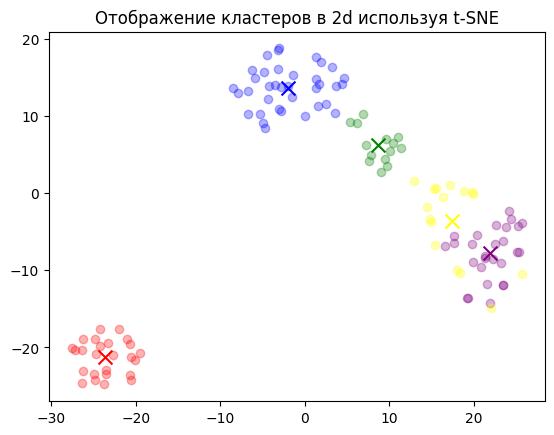

In [14]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue", "yellow"]):
    xs = np.array(x)[df.сluster == category]
    ys = np.array(y)[df.сluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Отображение кластеров в 2d используя t-SNE")


Как мы видим четыре из пяти кластеров расположились относительно "рядом". Это говорит о том, что они приблизительно схожи по тематике.

В то же время как кластер снизу слева наоборот находится далеко от других.

# Составляем названия для кластеров

Для того чтобы выделить названия для кластеров, мы возьмём по пять случайных сообщений в каждем кластере и попросим модель `gpt-3.5-turbo` из ChatGPT описать что у них есть общего ~~ради хайпового заголовка~~, потому что сейчас это одна из самых качественных моделей для суммаризации от OpenAI. В то же время модель `text-davinci-003` так же отлично подойдёт, но будет стоить в 10 раз дороже.

Стоит обратить внимание на то, что стоимость генерации выйдет дороже получения эмбеддингов. Стоимость можно ограничивать, контролируя размез `promt`. Или же размер выдачи, изменяя параметр `max_tokens`

In [16]:
rev_per_cluster = 5

for i in range(n_clusters):
    joined_messages = "\n".join(
        df[df['сluster'] == i]
        .message
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "user", 
                "content": f'Что общего у этих обращений?\n\nОбращения:\n"""\n{joined_messages}\n"""\n\nТема:'
            }
        ],
        temperature=0, 
        max_tokens=128, # Этот параметр можно изменять для более подробного или короткого описания
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(f"Тема кластера №{i}: ", response['choices'][0]['message']['content'].replace("\n", ""), '\n')
    print(joined_messages)
    print('\n\n')


Тема кластера №0:  Изменение времени приема у врача. 

Как отменить изменение времени приема?
Есть ли ограничения по количеству раз, когда можно изменить время приема?
Могу ли я изменить время приема через интернет?
Какие данные нужно предоставить для изменения времени приема?
Могу ли я выбрать время приема врача?



Тема кластера №1:  медицинские справки и их получение. 

Какие медицинские справки нужны для трудоустройства?
Какие медицинские справки нужны для получения водительского удостоверения?
Как получить медицинскую справку?
Какие медицинские справки нужны для выезда за границу?
Могу ли я получить медицинскую справку по почте или электронной почте?



Тема кластера №2:  пластическая хирургия. 

Добрый день, я хочу сделать операцию по подтяжке лица. Как долго будет идти восстановление после операции?
Добрый день, я хотел бы узнать о возможностях пластической операции по удалению рубцов.
Здравствуйте, я хотел бы узнать, какую процедуру можно сделать для коррекции формы бровей?
Доб

# Проверочная работа

У нас теперь есть описание кластеров от `gpt-3.5-turbo`. Эти названия можно сопоставить с тем как мы разметили сообщения в начале.

In [17]:
df['cluster_name'] = df['сluster'].replace(
    {
        0: 'Изменение времени приема',
        1: 'Справки',
        2: 'Пластическая хирургия',
        3: 'Результаты анализов',
        4: 'Запись на прием'
    }
)


Выведем ошибки

In [18]:
df[df['class'] != df['cluster_name']]

,message,class,n_tokens,embedding,сluster,cluster_name
4,Могу ли я выбрать время приема врача?,Запись на прием,17,"[-0.0005684721982106566, -0.007330173626542091...",0,Изменение времени приема
7,Как изменить время записи на прием?,Запись на прием,11,"[-0.0019539822824299335, -0.0093830656260252, ...",0,Изменение времени приема
14,Как изменить время приема?,Запись на прием,9,"[0.003285796847194433, -0.008702383376657963, ...",0,Изменение времени приема
34,Как отменить прием?,Изменение времени приема,8,"[-0.00467408262193203, -0.008316137827932835, ...",4,Запись на прием


Их всего 4 на 118 сообщений. И то это сложно назвать ошибками, т.к. эти сообщения действительно можно отнести к двум кластерам сразу.

В итоге за $0.04 (за эмбеддинги и кластеризацию) мы разметили больше сотни сообщений быстрее чем за пять минут!

Даже если учесть, что в части сообщений мы точно ошибёмся, то количество ошибок будет вряд-ли больше чем при человеческой разметке.

Однако стоит учитывать, что никакая модель без дообучения не будет знать нюансов и бизнес процессов компании и это стоит использовать как поверхностную аналитику, нежели руководство к действию.